# Import libraries

In [1]:
import sys
import os
sys.path.append('Devices/Taiko/')
import time
import numpy as np
from snAPI.Main import *
import TaikoON_OFF as tk
import Motor_f as mot
import matplotlib.pyplot as plt
import pyfirmata
import inspect

if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = inspect.getfullargspec

# Functions

In [2]:
def Focusing(handlez,sn,z0,z1,step,wait):
    sn.timeTrace.measure(100000, False, False)
    count_arr=np.array([])
    z_arr=np.arange(z0,z1,step)
    for zi in z_arr:
        mot.move_abs_z(zdrive,zi)
        sn.timeTrace.clearMeasure()
        time.sleep(wait)
        counts, _ = sn.timeTrace.getData() 
        count_arr=np.append(count_arr,np.sum(counts[ch]))
    sn.timeTrace.stopMeasure()
    return count_arr,z_arr  

In [3]:
def GetScanSequence(x0,xf,Nx,y0,yf,Ny):
    xs=np.linspace(x0,xf,Nx)
    ys=np.linspace(y0,yf,Ny)
    XY=np.meshgrid(xs,ys)
    Order=np.zeros_like(XY[0])
    for i in range(0,np.shape(XY[0])[0]):
        for j in range(0,np.shape(XY[0])[1]):
            if j%2==0:
                Order[i,j]=i+Ny*j
            else:
                Order[i,j]=Nx-i-1+Ny*j
    xx,yy,o=XY[0].flatten(),XY[1].flatten(),Order.flatten()
    xsorted=[x for _, x in sorted(zip(o,xx))]
    ysorted=[x for _, x in sorted(zip(o, yy))]
    pairs=np.vstack((xsorted,ysorted)).T
    return pairs

In [4]:
def XY_scan_no_markers(handlex,handley,x0,xf,Nx,y0,yf,Ny,texp,folder):# positions in micrometers
    #Create the scanning pattern (it is important to be ordered to minimize displacements)
    pairs=GetScanSequence(x0,xf,Nx,y0,yf,Ny)
    # The points of the scan are saved at pairs (ordered)
    prev_point=pairs[0]
    for point in pairs:
        if point[0]!=prev_point[0]:
            mot.move_abs_xy(handlex,point[0]) #move functions work in micrometers
        if point[1]!=prev_point[1]:
            mot.move_abs_xy(handley,point[1])
        timems=int(1000*texp)
        sn.setPTUFilePath(impath+"{}/PTU_{:.2f}_{:.2f}.ptu".format(folder,point[0],point[1]))
        sn.histogram.measure(timems,savePTU=True)
        #print('Stages={}, Measure+save={}'.format(t1-t0,t2-t1))
    return True

In [5]:
def TTL(board,ch):
    board.digital[ch].write(1)
    board.digital[ch].write(0)
    return True

In [45]:
def XY_scan_markers(handlex,handley,x0,xf,Nx,y0,yf,Ny,texp,folder):# positions in micrometers
    #Create the scanning pattern (it is important to be ordered to minimize displacements)
    pairs=GetScanSequence(x0,xf,Nx,y0,yf,Ny)
    # The points of the scan are saved at pairs (ordered)
    sn.setPTUFilePath(impath+"{}/PTU.ptu".format(folder))
    prev_point=pairs[0]
    mot.move_abs_xy(handlex,prev_point[0])
    mot.move_abs_xy(handley,prev_point[1])
    sn.histogram.measure(acqTime=0,waitFinished=False,savePTU=True) #check buffersize...
    time.sleep(2)
    for point in pairs:
        if point[0]!=prev_point[0]:
            TTL(board,11)
            mot.move_abs_xy(handlex,point[0]) #move functions work in micrometers
            TTL(board,13)
        if point[1]!=prev_point[1]:
            TTL(board,12)
            mot.move_abs_xy(handley,point[1])
            TTL(board,13)
        time.sleep(texp)
        prev_point=point
    sn.histogram.stopMeasure()
    return True

In [7]:
def Lifetime(sn,texp):
    sn.histogram.measure(texp*1000, True, False)
    data, bins = sn.histogram.getData()
    return data,bins  

In [8]:
def GetCountRate(sn,ch,texp):
    sn.initDevice(MeasMode.T2)
    sn.timeTrace.measure(texp*1000, True, False)
    data, bins = sn.timeTrace.getData()
    return np.mean(data[ch])

In [9]:
def Timetrace(sn,texp):
    sn.timeTrace.setHistorySize(historySize=texp)
    sn.timeTrace.measure(texp*1000, True, False)
    data, bins = sn.timeTrace.getData()
    return data,bins  

In [10]:
def create_folder(path):
    try: 
        os.mkdir(path) 
    except OSError as error: 
        print(error)  

# Connections

## Connect motors

### Piezos (for scanning)

In [11]:
xdrive=mot.connectX()
ydrive=mot.connectY()

---- Connecting PDXC motor ----
Devices=[['01403418', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM11&COM'], ['01404934', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM10&COM']]
connect  01403418
Found PDX1 stage
-- Stage settings --
-  closed loop mode  -
set loop to closed loop
-  Manual Mode  -
set trigger mode to manual mode
set PositionCalibration home
get CalibrationIsCompleted: done
set TargetSpeed to 20
---- Connecting PDXC motor ----
Devices=[['01403418', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM11&COM'], ['01404934', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM10&COM']]
connect  01404934
Found PDX1 stage
-- Stage settings --
-  closed loop mode  -
set loop to closed loop
-  Manual Mode  -
set trigger mode to manual mode
set PositionCalibration home
get CalibrationIsCompleted: done
set TargetSpeed to 20


### Z axis (For focusing)

In [12]:
zdrive=mot.connectZ()

Found Device 1 SN: 61516 (T-NA08A25) -> Connection 1 (Binary Serial port: COM5) devices
-Homed-


## Connect HydraHarp

In [13]:
sn = snAPI(libType=LibType.HH)
sn.getDeviceIDs()
print('Available devices are:'+str(sn.deviceIDs))

Available devices are:['1039212', '', '', '', '', '', '', '']


In [14]:
sn.getDevice('1039212')
sn.initDevice(MeasMode.T3)
sn.loadIniConfig("config\HH.ini")
sn.device.setBinning(8)
sn.device.setSyncDiv(8)

1

In [15]:
sn.device.setMarkerEnable(1,1,1,1)
sn.device.setMarkerEdges(1,1,1,1)

1

In [16]:
sn.getDeviceConfig()
print(sn.deviceConfig)

{'DeviceType': 0, 'FileDevicePath': '', 'ID': '1039212', 'Index': 0, 'Model': 'HydraHarp 400', 'PartNo': '930021', 'Version': '2.0', 'BaseResolution': 1.0, 'Resolution': 256.0, 'BinSteps': 26, 'NumChans': 4, 'NumMods': 4, 'SyncDivider': 8, 'SyncTrigMode': 'CFD', 'SyncDiscrLvl': 50, 'SyncZeroxLvL': 0, 'SyncChannelOffset': -10000, 'SyncChannelEnable': 1, 'SyncDeadTime': 0, 'HystCode': 0, 'TimingMode': 0, 'StopCount': 4294967295, 'Binning': 8, 'Offset': 0, 'LengthCode': 6, 'NumBins': 32768, 'MeasCtrl': 0, 'StartEdge': 0, 'StopEdge': 0, 'TriggerOutput': 0, 'MarkerHoldoffTime': 0, 'HoldTime': 2, 'OflCompression': 2, 'MarkerEdges': [1, 1, 1, 1], 'MarkerEna': [1, 1, 1, 1], 'ModsCfg': [{'Index': 0, 'ModelCode': 1000, 'VersionCode': 51052545}, {'Index': 1, 'ModelCode': 1010, 'VersionCode': 33554954}, {'Index': 2, 'ModelCode': 1040, 'VersionCode': 18219530}, {'Index': 3, 'ModelCode': 1040, 'VersionCode': 18219530}], 'ChansCfg': [{'Index': 0, 'TrigMode': 'CFD', 'DiscrLvl': 50, 'ZeroXLvl': 0, 'Cha

In [17]:
sn.deviceConfig['Resolution']

256.0

## Connect Taiko laser

In [18]:
laser_id=tk.ON(reprate=1e6,perc=50)

  [ Python ]                               Library version: 2.1.64.4505

  USB-Driver Service: 'WINUSB'; V1.0.0.3, 20.07.2023

  USB-Index 0: PDL-M1 with serial number 1047648 found (ready to run)
  USB-Index 0: PDL-M1 opened.

  - FW   : 2.1.4513
  - FPGA : 2.3
  - LH   : 1.0

  Laser is NOT locked by On/Off Button
  Laser is NOT locked by key

  Connected laser head:
  - laser head type       : LDH-IB-375-B
  - date of manufacturing : 23-02-13
  - laser power class     : 3B
  - frequency range       :   1  Hz -  80 MHz

  Frequency currently set :  10 MHz
  Frequency now set to    :   1 MHz
  Pulse power set to      :   5.0 %  ==>  3.513 μW

  Got via TagList:
  -                  Frequency :   1 MHz
  -                  TempScale :   0  ==>  °C
  -                 TargetTemp :  37.0 °C
  -               TriggerLevel :   0.000 V
  -        LDH_PulsePowerTable :   0  ==> linear power mode
  -        TriggerLevelHiLimit :   1.065  W
  -         PulsePowerPermille :  50 permille  ==>   

In [19]:
#tk.setRepRate(laser_id,1e6)
tk.setPermille(laser_id,500)

  Frequency now set to    : 500  permille


In [20]:
#tk.OFF(laser_id)

## Connect Arduino

In [20]:
board = pyfirmata.Arduino('COM6')

# Measurements

## Data folder

Write name of the sample to create a folder for it

In [21]:
sname='Trial_markers_QD'

In [22]:
dpath='./Data/'
spath=dpath+sname+'/'
create_folder(spath)

[WinError 183] No se puede crear un archivo que ya existe: './Data/Trial_markers_QD/'


## Select position

In [87]:
x0=30 ## positions are in micrometers
y0=3
mot.move_abs_xy(xdrive,x0)
mot.move_abs_xy(ydrive,y0)

## Focusing

In [88]:
ch=3

In [93]:
tk.setRepRate(laser_id,1e7)
tk.setPermille(laser_id,500)

  Frequency now set to    :  10 MHz
  Frequency now set to    : 500  permille


In [94]:
counts,zs=Focusing(zdrive,sn,2280,2300,1,0.1)

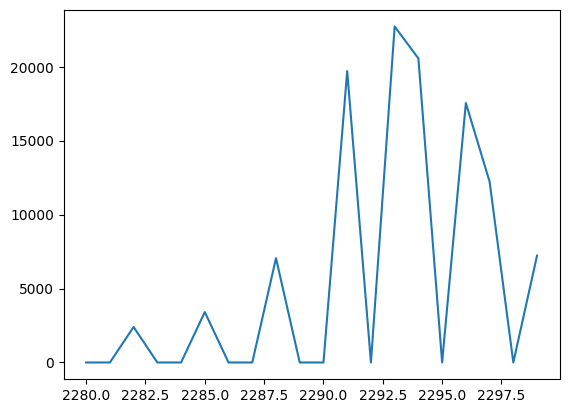

In [95]:
plt.plot(zs,counts)

In [96]:
mot.move_abs_z(zdrive,2292)

## Check count rates

In [97]:
tk.setPermille(laser_id,500)
sync_cr=GetCountRate(sn,0,1)
ch_cr=GetCountRate(sn,3,1)
tk.setPermille(laser_id,0)
print('Sync count rate: {}'.format(sync_cr))
print('Channel count rate: {}'.format(ch_cr))
print('Pulses per sync (%): {}'.format(ch_cr/sync_cr*100))
sn.initDevice(MeasMode.T3)
sn.loadIniConfig("config\HH.ini")
sn.device.setBinning(8)

  Frequency now set to    : 500  permille
  Frequency now set to    : 0 Gpermille
Sync count rate: 80011.19
Channel count rate: 237.72
Pulses per sync (%): 0.2971084419566813


1

## Timetrace

In [80]:
x0=0 ## positions are in micrometers
y0=0

mot.move_abs_xy(xdrive,x0)
mot.move_abs_xy(ydrive,y0)

In [98]:
save=False
if save:
    ttpath=spath+'TimeTraces/'
    create_folder(ttpath)

In [99]:
if save:
    sn.setPTUFilePath(ttpath+"PTU_{:.2f}_{:.2f}.ptu".format(folder,point[0],point[1]))
texp=100
tk.setRepRate(laser_id,1e6)
tk.setPermille(laser_id,1000)
sn.timeTrace.setHistorySize(historySize=texp)
sn.timeTrace.setNumBins(numBins=500)
sn.timeTrace.measure(texp*1000, True, save)
data, bins = sn.timeTrace.getData()
tk.setPermille(laser_id,0)

  Frequency now set to    :   1 MHz
  Frequency now set to    : 1 kpermille
  Frequency now set to    : 0 Gpermille


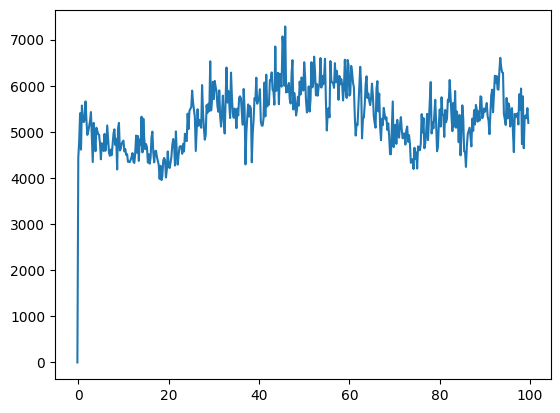

In [100]:
plt.plot(bins,data[3])

In [51]:
bins

array([89.995, 89.996, 89.997, ..., 99.992, 99.993, 99.994])

## Lifetime measurement

In [101]:
sn.initDevice(MeasMode.T3)
sn.loadIniConfig("config\HH.ini")
sn.device.setBinning(8)
sn.device.setSyncDiv(1)

1

In [102]:
tk.setRepRate(laser_id,1e6)
tk.setPermille(laser_id,500)
print('Measuring')
data,bins=Lifetime(sn,1)
tk.setPermille(laser_id,0)

  Frequency now set to    :   1 MHz
  Frequency now set to    : 500  permille
Measuring
  Frequency now set to    : 0 Gpermille


(0.0, 3000.0)

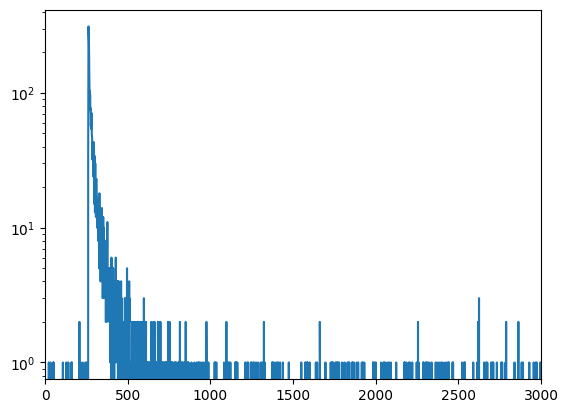

In [103]:

plt.plot(bins,data[3])
plt.yscale('log')
#plt.xscale('log')
plt.xlim([0,3e3])

## Scanning

In [104]:
xran=10
yran=10
nx=50
ny=50
texp=0.1
impath=spath
tk.setRepRate(laser_id,1e6)
tk.setPermille(laser_id,50)
XY_scan_markers(xdrive,ydrive,x0-xran/2,x0+xran/2,nx,y0-yran/2,y0+yran/2,ny,texp,'T')
tk.setPermille(laser_id,0)

  Frequency now set to    :   1 MHz
  Frequency now set to    : 50  permille
  Frequency now set to    : 0 Gpermille
